In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

from tqdm import tqdm

In [3]:
plt.style.use('ggplot')

In [4]:
years = [
    2023, 2024, 2025
]

In [5]:
data = pd.DataFrame()

for y in tqdm(years):
    df = pd.read_csv(f'data/date-hour-soo-dest-{y}.csv').T.reset_index().T
    data = pd.concat([data, df], axis=0)

data.head()

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:23<00:00,  7.79s/it]


,0,1,2,3,4
index,2023-01-01,0,12TH,12TH.1,1
0,2023-01-01,0,12TH,16TH,1
1,2023-01-01,0,12TH,19TH,2
2,2023-01-01,0,12TH,24TH,3
3,2023-01-01,0,12TH,ASHB,2


In [6]:
data.shape

(23805046, 5)

In [7]:
data = data.rename({
    0: 'date',
    1: 'hour',
    2: 'origin',
    3: 'dest',
    4: 'riders'
}, axis=1)
data.head(1)

,date,hour,origin,dest,riders
index,2023-01-01,0,12TH,12TH.1,1


Station codes in the dictionary below from BART Legacy API website: https://api.bart.gov/docs/overview/abbrev.aspx

In [50]:
station_codes = {
    "12TH": "12th St. Oakland City Center",
    "16TH": "16th St. Mission (SF)",
    "19TH": "19th St. Oakland",
    "24TH": "24th St. Mission (SF)",
    "ASHB": "Ashby (Berkeley)",
    "ANTC": "Antioch",
    "BALB": "Balboa Park (SF)",
    "BAYF": "Bay Fair (San Leandro)",
    "BERY": "Berryessa / North San Jose",
    "CAST": "Castro Valley",
    "CIVC": "Civic Center (SF)",
    "COLS": "Coliseum",
    "COLM": "Colma",
    "CONC": "Concord",
    "DALY": "Daly City",
    "DBRK": "Downtown Berkeley",
    "DUBL": "Dublin/Pleasanton",
    "DELN": "El Cerrito del Norte",
    "PLZA": "El Cerrito Plaza",
    "EMBR": "Embarcadero (SF)",
    "FRMT": "Fremont",
    "FTVL": "Fruitvale (Oakland)",
    "GLEN": "Glen Park (SF)",
    "HAYW": "Hayward",
    "LAFY": "Lafayette",
    "LAKE": "Lake Merritt (Oakland)",
    "MCAR": "MacArthur (Oakland)",
    "MLBR": "Millbrae",
    "MLPT": "Milpitas",
    "MONT": "Montgomery St. (SF)",
    "NBRK": "North Berkeley",
    "NCON": "North Concord/Martinez",
    "OAKL": "Oakland Int'l Airport",
    "ORIN": "Orinda",
    "PITT": "Pittsburg/Bay Point",
    "PCTR": "Pittsburg Center",
    "PHIL": "Pleasant Hill",
    "POWL": "Powell St. (SF)",
    "RICH": "Richmond",
    "ROCK": "Rockridge (Oakland)",
    "SBRN": "San Bruno",
    "SFIA": "San Francisco Int'l Airport",
    "SANL": "San Leandro",
    "SHAY": "South Hayward",
    "SSAN": "South San Francisco",
    "UCTY": "Union City",
    "WARM": "Warm Springs/South Fremont",
    "WCRK": "Walnut Creek",
    "WDUB": "West Dublin",
    "WOAK": "West Oakland"
}

In [9]:
data['date'] = pd.to_datetime(data['date'])
data['hour'] = data['hour'].astype(int)
data['riders'] = data['riders'].astype(int)

In [10]:
data['day_of_wk'] = data['date'].dt.day_name()
data.head()

,date,hour,origin,dest,riders,day_of_wk
index,2023-01-01,0,12TH,12TH.1,1,Sunday
0,2023-01-01,0,12TH,16TH,1,Sunday
1,2023-01-01,0,12TH,19TH,2,Sunday
2,2023-01-01,0,12TH,24TH,3,Sunday
3,2023-01-01,0,12TH,ASHB,2,Sunday


In [11]:
data_wkday = data[data['day_of_wk'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])]

In [12]:
# Get dataframe with average riders for each route per hour, only aggregating weekdays
routes_by_hr_wkday = data_wkday[['hour', 'origin', 'dest', 'riders']].groupby(['hour', 'origin', 'dest']).agg('mean')
routes_by_hr_wkday.shape

(53947, 1)

In [13]:
routes_by_hr_wkday = routes_by_hr_wkday.reset_index()
routes_by_hr_wkday.head()

,hour,origin,dest,riders
0,0,12TH,12TH,1.891089
1,0,12TH,12TH.1,2.000000
2,0,12TH,16TH,1.400990
3,0,12TH,19TH,1.085106
4,0,12TH,24TH,1.410138


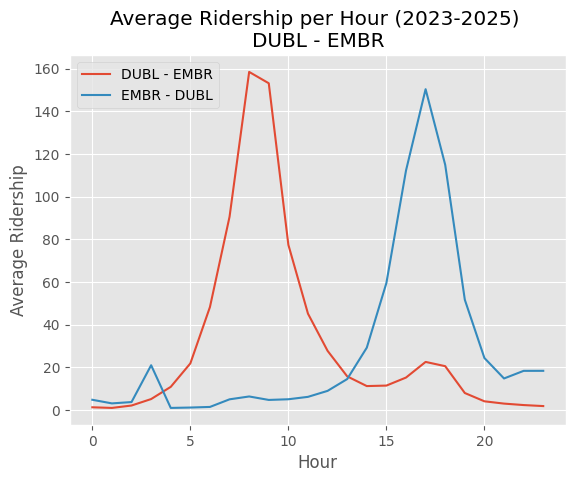

In [14]:
## Average ridership per hour for a specific route

station_1 = "DUBL"
station_2 = "EMBR"

plt.plot(
    routes_by_hr_wkday[ (routes_by_hr_wkday['origin'] == station_1) & (routes_by_hr_wkday['dest'] == station_2) ]['hour'],
    routes_by_hr_wkday[ (routes_by_hr_wkday['origin'] == station_1) & (routes_by_hr_wkday['dest'] == station_2) ]['riders'],
    label = f'{station_1} - {station_2}'
)
plt.plot(
    routes_by_hr_wkday[ (routes_by_hr_wkday['origin'] == station_2) & (routes_by_hr_wkday['dest'] == station_1) ]['hour'],
    routes_by_hr_wkday[ (routes_by_hr_wkday['origin'] == station_2) & (routes_by_hr_wkday['dest'] == station_1) ]['riders'],
    label = f'{station_2} - {station_1}'
)
plt.xlabel('Hour')
plt.ylabel('Average Ridership')
plt.title(f'Average Ridership per Hour (2023-2025) \n{station_1} - {station_2}')
plt.legend();

In [15]:
exits_by_hr = data[['date', 'hour', 'dest', 'riders']].groupby(['date', 'hour', 'dest']).agg('sum').reset_index().groupby(
    ['hour', 'dest']
).agg('mean').reset_index()
exits_by_hr.head()

,hour,dest,date,riders
0,0,12TH,2024-05-02 07:04:18.726899456,29.185832
1,0,12TH.1,2023-07-02 12:00:00.000000000,1.500000
2,0,16TH,2024-05-02 12:00:00.000000000,30.288934
3,0,19TH,2024-05-02 07:04:18.726899456,31.010267
4,0,24TH,2024-05-02 12:00:00.000000000,33.339139


In [16]:
exits_by_hr.shape

(1201, 4)

In [17]:
exits_by_hr_wkday = data[data['day_of_wk'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])][[
 'date', 'hour', 'dest', 'riders']].groupby(['date', 'hour', 'dest']).agg('sum').reset_index().groupby(
    ['hour', 'dest']
 ).agg('mean').reset_index()
exits_by_hr_wkday.head()

,hour,dest,date,riders
0,0,12TH,2024-05-02 09:38:28.751793408,23.286944
1,0,12TH.1,2024-01-01 00:00:00.000000000,2.000000
2,0,16TH,2024-05-02 09:38:28.751793408,22.441894
3,0,19TH,2024-05-02 09:38:28.751793408,22.885222
4,0,24TH,2024-05-02 09:38:28.751793408,25.446198


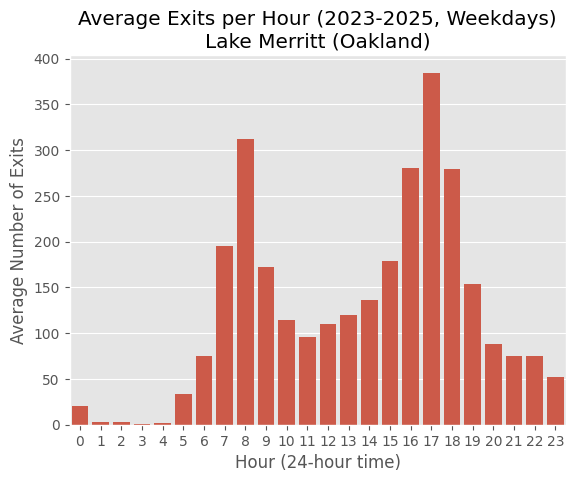

In [118]:
station_lower = 'lake'
station = station_lower.upper()
station_fullname = station_codes[station]

sns.barplot(
    data = exits_by_hr_wkday[exits_by_hr_wkday['dest'] == station],
    x = 'hour',
    y = 'riders'
)
plt.xlabel('Hour (24-hour time)')
plt.ylabel('Average Number of Exits')
plt.title(f'Average Exits per Hour (2023-2025, Weekdays)\n{station_fullname}');

In [82]:
np.sum(exits_by_hr_wkday[exits_by_hr_wkday['dest'] == station]['riders'])

2439.569982482219

### Arrivals/Departures & Land Use

As described in the [BART Ridership snapshot for April 2025](https://www.bart.gov/sites/default/files/2025-05/202504%20Monthly%20Ridership%20Snapshot.pdf), the arrivals/departures ratio during AM commute times can be useful as a proxy for land use. Stations with more departures are likely to have more residential land use (housing-focused), whereas stations with more arrivals are likely to have more commerical, industrial, and office land use (jobs-focused). Those with a balance between arrivals and departures during AM commute times have more balanced land use. Note that this is a general proxy and may not be applicable in certain cases, i.e. arrivals/departures from SF and Oakland Int'l airports.

The ridership snapshot provides a handy chart for this, but it is limited in readability. We can visualize and analyze arrival/departure ratio with hourly ridership data.

In [121]:
# Filter for AM commute times on weekdays
am_commutes = data[
    (data['hour'] >= 4) & (data['hour'] <= 11) & (~data['day_of_wk'].isin(['Sunday', 'Saturday']))
]
am_commutes.head()

,date,hour,origin,dest,riders,day_of_wk
16218,2023-01-02,4,12TH,12TH,2,Monday
16219,2023-01-02,4,ANTC,ANTC,1,Monday
16220,2023-01-02,4,ANTC,PCTR,1,Monday
16221,2023-01-02,4,BALB,BALB,2,Monday
16222,2023-01-02,4,CIVC,CIVC,1,Monday


In [122]:
am_commutes.shape

(6462513, 6)

In [133]:
departures_am = am_commutes.groupby(['origin']).agg({'riders': 'sum'}).reset_index().rename({'riders': 'departures'}, axis=1)
exits_am = am_commutes.groupby(['dest']).agg({'riders': 'sum'}).reset_index().rename({'riders': 'arrivals'}, axis=1)
departures_am.head()

,origin,departures
0,12TH,1105282
1,16TH,1034370
2,19TH,1217866
3,24TH,1544874
4,ANTC,969531


In [135]:
exits_am.head()

,dest,arrivals
0,12TH,1695730
1,16TH,1556570
2,19TH,1298910
3,24TH,1090187
4,ANTC,101070


In [151]:
deps_arrs = pd.merge(left=departures_am, right=exits_am, left_on='origin', right_on='dest').drop(['dest'], axis=1).rename(
    {
        'origin': 'station_code'
    }, axis=1
)
deps_arrs['station_name'] = deps_arrs['station_code'].map(lambda x: station_codes[x])
deps_arrs['arr_dep_ratio'] = deps_arrs['arrivals'] / deps_arrs['departures']
deps_arrs['arr_pct'] = deps_arrs['arrivals'] / (deps_arrs['arrivals'] + deps_arrs['departures']) # Technically proportion, not percentage
deps_arrs = deps_arrs[['station_code', 'station_name', 'departures', 'arrivals', 'arr_dep_ratio', 'arr_pct']]
deps_arrs.head()

,station_code,station_name,departures,arrivals,arr_dep_ratio,arr_pct
0,12TH,12th St. Oakland City Center,1105282,1695730,1.534206,0.605399
1,16TH,16th St. Mission (SF),1034370,1556570,1.504848,0.600774
2,19TH,19th St. Oakland,1217866,1298910,1.066546,0.516101
3,24TH,24th St. Mission (SF),1544874,1090187,0.705680,0.413724
4,ANTC,Antioch,969531,101070,0.104246,0.094405


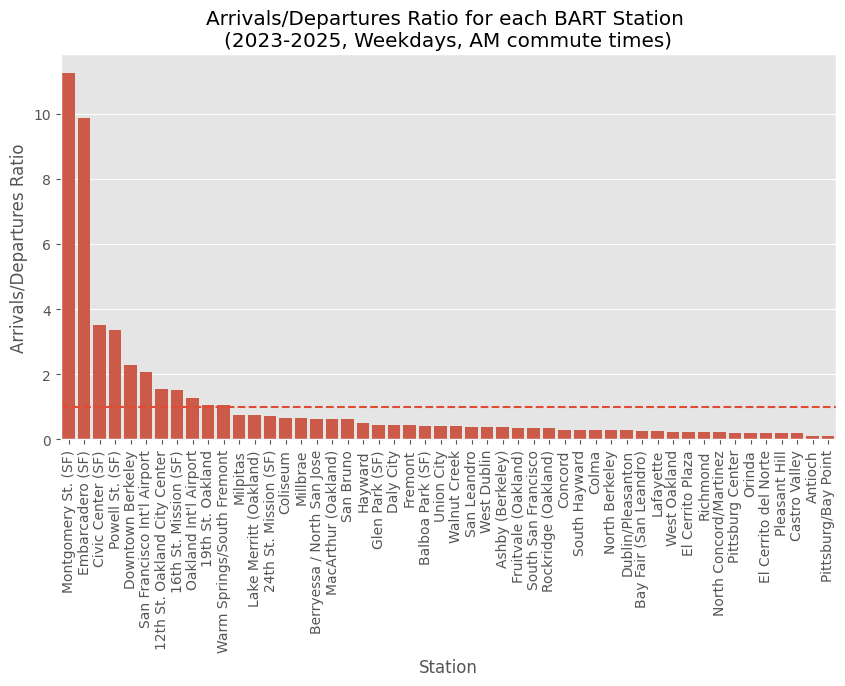

In [185]:
plt.figure(figsize=(10, 5))
sns.barplot(
    data = deps_arrs.sort_values(['arr_dep_ratio'], ascending=False),
    x = 'station_name',
    y = 'arr_dep_ratio'
)
plt.xlabel('Station')
plt.ylabel('Arrivals/Departures Ratio')
plt.title('Arrivals/Departures Ratio for each BART Station \n(2023-2025, Weekdays, AM commute times)')
plt.xticks(rotation=90)
plt.axhline(y = 1, linestyle = '--');